## 21D008 Probabilistic Inference - Project: Elliptical Slice Sampling in Classification

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats import multivariate_normal
from numpy.random import multivariate_normal as mn
from gpc import *
from EllipticalSliceSampler import EllipticalSampler
from utils import (
    plot_sampler,
    plot_multiple,
    plot_contour,
    gaussian_kernel
)
np.random.seed(42)
cmap=colors.LinearSegmentedColormap.from_list('rg',["tab:green", "tab:red"], N=256)

In [2]:
prior_µ = np.array([1,2])
prior_Σ = np.array(
    [[ 2.58319407, -0.67001488],
    [-0.67001488,  1.09846023]]
)

lik_µ = np.array([0,0])
lik_Σ = np.array(
    [[ 1.80406008, -1.01247719],
    [-1.01247719,  1.34016259]]
)

loglik = lambda f: np.log(multivariate_normal.pdf(f, mean=lik_µ, cov=lik_Σ))
f_incumbent = mn(prior_µ - prior_µ, prior_Σ, size=1).squeeze()

nu = mn(prior_µ - prior_µ, prior_Σ, size=1)
log_y = loglik(f_incumbent) + np.log(np.random.uniform(0,1))
Θ = np.random.uniform(0 + sys.float_info.min, 2*np.pi)
Θ_min, Θ_max = Θ - 2*np.pi, Θ

In [3]:
f_candidate = (f_incumbent * np.cos(Θ) + nu * np.sin(Θ)).squeeze()

In [4]:
Θ_space = np.linspace(0,2*np.pi,100)

In [5]:
pointy = np.stack([(f_incumbent * np.cos(x) + nu * np.sin(x)).squeeze() for x in Θ_space])

In [6]:
f_candidate

array([-0.89048893,  1.50953396])

Text(0.5, 1.0, '$L(f_t)=$-2.24$\\quadL(f_{t+1})=$-2.88$\\quad[Θ_{min},\\;Θ_{max}]=$[-5.3, 0.98]')

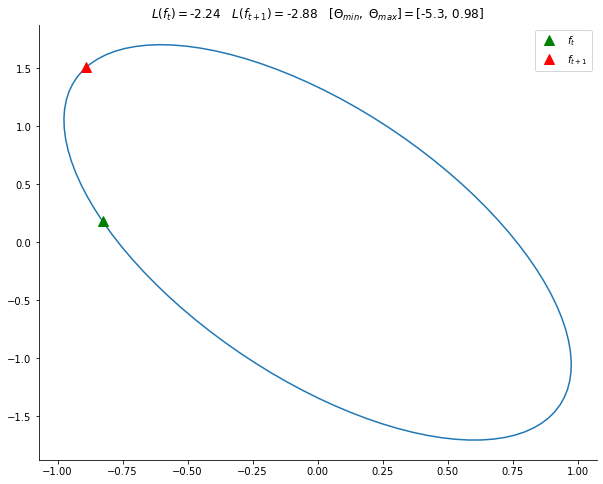

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(pointy[:,0], pointy[:,1])
ax.plot(f_incumbent[0], f_incumbent[1], 'g^', markersize=10, label="$f_t$")
ax.plot(f_candidate[0], f_candidate[1], 'r^', markersize=10, label="$f_{t+1}$")
ax.legend(loc="upper right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(
    "$L(f_t)=$" +
    str(round(loglik(f_incumbent),2)) +
    "$\quadL(f_{t+1})=$" +
    str(round(loglik(f_candidate),2)) +
    "$\quad[Θ_{min},\;Θ_{max}]=$" + "[" + str(round(Θ_min,2)) + ", " + str(round(Θ_max,2)) +"]"
)

### Toy Example: GPC

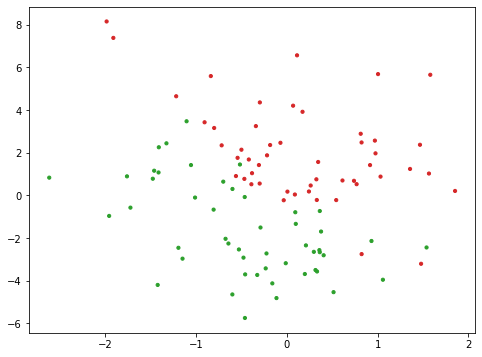

In [8]:
X1 = np.random.standard_normal(size=100)
X2 = np.random.normal(0,3,size=100)
X = np.dstack((X1,X2)).squeeze()
Y = np.where(0.5*X1 + 0.3*X2 + np.random.normal(0,0.2,100) > 0, 1, 0)

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.scatter(x=X[:,0], y=X[:,1], s=10, c=np.where(Y>0, "tab:red", "tab:green"))

In [9]:
train_X, train_Y = X[:80,:], Y[:80]
test_X, test_Y = X[80:,:], Y[80:]

In [10]:
gpc = GPC(kernel=gaussian_kernel, hyperparameters=[1,1])
gpc.X, gpc.Y = train_X, train_Y

In [11]:
y_pred, var_pred = gpc.predict(test_X)
prob_pred = GPC._sigmoid(y_pred)

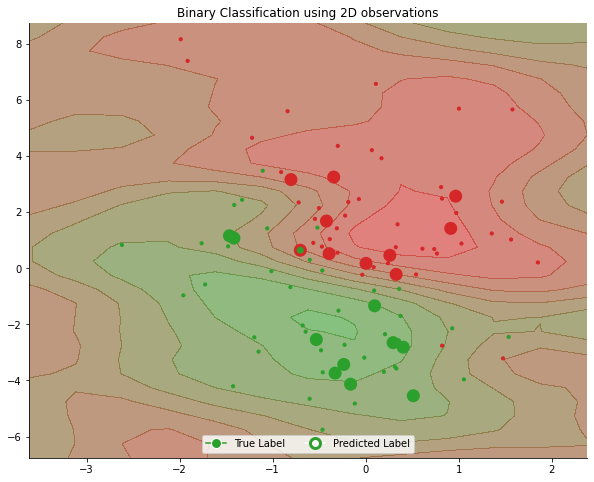

In [13]:
plot_contour(train_X, train_Y, test_X, test_Y, prob_pred, gpc, cmap, contour=True)

In [55]:
len(prob_pred)

80